<p style="text-align:center">
    <a href="https://skills.network" target="_blank">
    <img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/assets/logos/SN_web_lightmode.png" width="200" alt="Skills Network Logo">
    </a>
</p>


# Machine Learning Foundation

## Course 5, Part d: Keras Intro LAB


## Using Keras to Build and Train Neural Networks


In this exercise we will use a neural network to predict diabetes using the Pima Diabetes Dataset.  We will start by training a Random Forest to get a performance baseline.  Then we will use the Keras package to quickly build and train a neural network and compare the performance.  We will see how different network structures affect the performance, training time, and level of overfitting (or underfitting).

## UCI Pima Diabetes Dataset

* UCI ML Repositiory (http://archive.ics.uci.edu/ml/datasets/Pima+Indians+Diabetes)


### Attributes: (all numeric-valued)
   1. Number of times pregnant
   2. Plasma glucose concentration a 2 hours in an oral glucose tolerance test
   3. Diastolic blood pressure (mm Hg)
   4. Triceps skin fold thickness (mm)
   5. 2-Hour serum insulin (mu U/ml)
   6. Body mass index (weight in kg/(height in m)^2)
   7. Diabetes pedigree function
   8. Age (years)
   9. Class variable (0 or 1)


In [12]:
RANDOM_STATE = 123

In [1]:
import skillsnetwork
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

2024-08-12 14:45:01.867957: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-08-12 14:45:02.072214: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-08-12 14:45:02.851114: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-08-12 14:45:06.475643: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [4]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam, SGD, RMSprop

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, precision_recall_curve, roc_auc_score, roc_curve, accuracy_score
from sklearn.ensemble import RandomForestClassifier

In [7]:
import warnings

warnings.filterwarnings("ignore")

In [8]:
await skillsnetwork.prepare("https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-ML311-Coursera/labs/Module2/L2/diabetes.csv", overwrite=True)

column_names = ["times_pregnant", "glucose_tolerance_test", "blood_pressure", "skin_thickness", "insulin", 
         "bmi", "pedigree_function", "age", "has_diabetes"]
diabetes_df = pd.read_csv('./diabetes.csv', names=column_names, header=0)

Saved to '.'


In [9]:
diabetes_df.head(5)

,times_pregnant,glucose_tolerance_test,blood_pressure,skin_thickness,insulin,bmi,pedigree_function,age,has_diabetes
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [10]:
Y_COLUMN = 'has_diabetes'

In [11]:
X = diabetes_df.drop(Y_COLUMN, axis=1)
y = diabetes_df[Y_COLUMN]

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=RANDOM_STATE)

In [15]:
y.value_counts(normalize=True)

has_diabetes
0    0.651042
1    0.348958
Name: proportion, dtype: float64

Above, we see that about 35% of the patients in this dataset have diabetes, while 65% do not.  This means we can get an accuracy of 65% without any model - just declare that no one has diabetes. We will calculate the ROC-AUC score to evaluate performance of our model, and also look at the accuracy as well to see if we improved upon the 65% accuracy.
## Exercise 1: Get a baseline performance using Random Forest
To begin, and get a baseline for classifier performance:
1. Train a Random Forest model with 200 trees on the training data.
2. Calculate the accuracy and roc_auc_score of the predictions.


In [16]:
rf_model = RandomForestClassifier(n_estimators=200)
rf_model.fit(X_train, y_train)

RandomForestClassifier(n_estimators=200)

In [17]:
y_pred_class_rf = rf_model.predict(X_test)
y_pred_prob_rf = rf_model.predict_proba(X_test)

In [18]:
print(f"accurary is: {accuracy_score(y_test, y_pred_class_rf)}")
print(f"roc_auc score is: {roc_auc_score(y_test, y_pred_prob_rf[:, 1])}")

accurary is: 0.7864583333333334
roc_auc score is: 0.8533440773569702


In [19]:
def plot_roc(y_test, y_pred, model_name):
    fpr, tpr, thr = roc_curve(y_test, y_pred)
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.plot(fpr, tpr, 'k-')
    ax.plot([0, 1], [0, 1], 'k--', linewidth=.5)
    ax.grid(True)
    ax.set(title=f"ROC Auc Curve for {model_name} on PIMA diabetes problem")

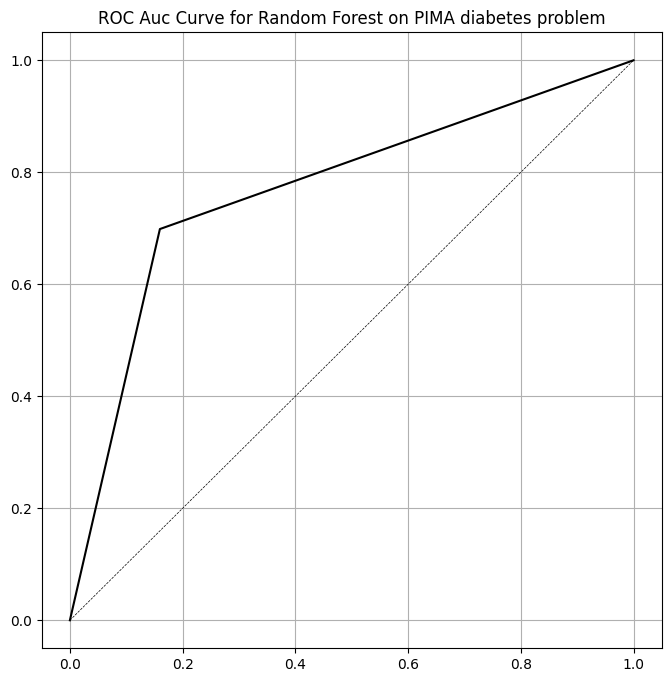

In [20]:
plot_roc(y_test, y_pred_class_rf, 'Random Forest')

## Build a Single Hidden Layer Neural Network

We will use the Sequential model to quickly build a neural network.  Our first network will be a single layer network.  We have 8 variables, so we set the input shape to 8.  Let's start by having a single hidden layer with 12 nodes.


In [22]:
normalizer = StandardScaler()
X_train_norm = normalizer.fit_transform(X_train)
X_test_norm = normalizer.fit_transform(X_test)

In [31]:
model_test = Sequential([
    Dense(4, input_shape=(3,), activation='sigmoid'),
    Dense(1, activation='sigmoid')
])
model_test.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_7 (Dense)                 │ (None, 4)              │            16 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 1)              │             5 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21 (84.00 B)

 Trainable params: 21 (84.00 B)

 Non-trainable params: 0 (0.00 B)

In [36]:
nn_model = Sequential([
    Dense(12, input_shape=(8,), activation='sigmoid'),
    Dense(1, activation='sigmoid')
])

In [37]:
nn_model.summary()

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_9 (Dense)                 │ (None, 12)             │           108 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 1)              │            13 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 121 (484.00 B)

 Trainable params: 121 (484.00 B)

 Non-trainable params: 0 (0.00 B)

### Comprehension question:
Why do we have 121 parameters?  Does that make sense?

Let's fit our model for 200 epochs.


In [38]:
nn_model.compile(SGD(learning_rate=0.003), 'binary_crossentropy', metrics=['accuracy'])
model_hist1 = nn_model.fit(X_train_norm, y_train, validation_data=(X_test_norm, y_test), epochs=200)

Epoch 1/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.3504 - loss: 0.8100 - val_accuracy: 0.3750 - val_loss: 0.7730
Epoch 2/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.3600 - loss: 0.7938 - val_accuracy: 0.3698 - val_loss: 0.7581
Epoch 3/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.3760 - loss: 0.7812 - val_accuracy: 0.3646 - val_loss: 0.7446
Epoch 4/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3707 - loss: 0.7650 - val_accuracy: 0.3854 - val_loss: 0.7327
Epoch 5/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4159 - loss: 0.7326 - val_accuracy: 0.4010 - val_loss: 0.7219
Epoch 6/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.3845 - loss: 0.7370 - val_accuracy: 0.4427 - val_loss: 0.7124
Epoch 7/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.4568 - loss: 0.7299 - val_accuracy: 0.4792 - val_loss: 0.7038
Epoch 8/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.4497 - loss: 0.7167 - val_accuracy: 0.4896 - v

In [40]:
y_pred_proba_nn = nn_model.predict(X_test_norm)
y_pred_class_nn = (y_pred_proba_nn > 1).astype(int)

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


In [41]:
y_pred_class_nn[: 10]

array([[0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0]])

In [42]:
print(f"accuracy is {accuracy_score(y_test, y_pred_class_nn)}")
print(f"roc_auc is {roc_auc_score(y_test, y_pred_proba_nn)}")

accuracy is 0.6197916666666666
roc_auc is 0.8220329227581443


Let's look at the `run_hist_1` object that was created, specifically its `history` attribute.


In [43]:
model_hist1.history.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

Let's plot the training loss and the validation loss over the different epochs and see how it looks.


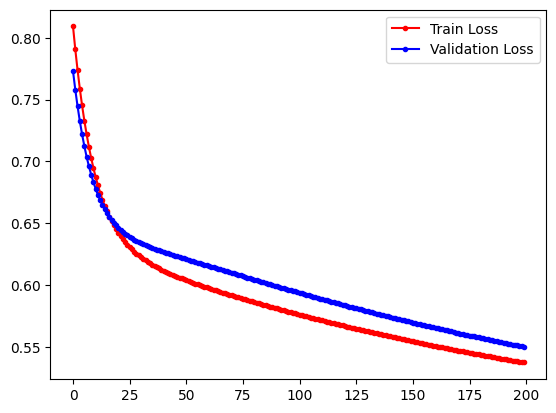

In [44]:
fig, ax = plt.subplots()
ax.plot(model_hist1.history["loss"],'r', marker='.', label="Train Loss")
ax.plot(model_hist1.history["val_loss"],'b', marker='.', label="Validation Loss")
ax.legend()

Looks like the losses are still going down on both the training set and the validation set.  This suggests that the model might benefit from further training.  Let's train the model a little more and see what happens. Note that it will pick up from where it left off. Train for 1000 more epochs.


In [45]:
hist_1b = nn_model.fit(X_train_norm, y_train, validation_data=(X_test_norm, y_test), epochs=500)

Epoch 1/500
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.7230 - loss: 0.5269 - val_accuracy: 0.7135 - val_loss: 0.5497
Epoch 2/500
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7323 - loss: 0.5270 - val_accuracy: 0.7135 - val_loss: 0.5493
Epoch 3/500
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.7168 - loss: 0.5350 - val_accuracy: 0.7135 - val_loss: 0.5490
Epoch 4/500
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7077 - loss: 0.5427 - val_accuracy: 0.7083 - val_loss: 0.5486
Epoch 5/500
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.7148 - loss: 0.5410 - val_accuracy: 0.7083 - val_loss: 0.5482
Epoch 6/500
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.6917 - loss: 0.5523 - val_accuracy: 0.7083 - val_loss: 0.5479
Epoch 7/500
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7062 - loss: 0.5273 - val_accuracy: 0.7083 - val_loss: 0.5475
Epoch 8/500
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.7312 - loss: 0.5269 - val_accuracy: 0.71

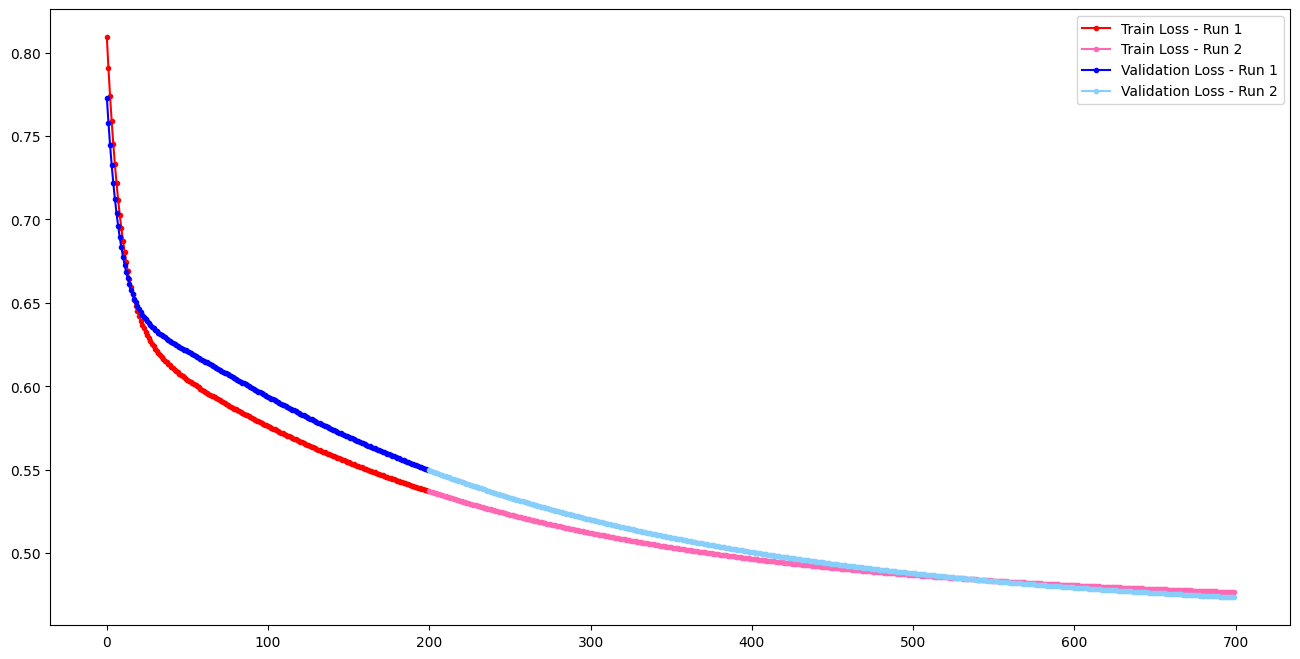

In [47]:
n = len(model_hist1.history["loss"])
m = len(hist_1b.history['loss'])
fig, ax = plt.subplots(figsize=(16, 8))

ax.plot(range(n), model_hist1.history["loss"],'r', marker='.', label="Train Loss - Run 1")
ax.plot(range(n, n+m), hist_1b.history["loss"], 'hotpink', marker='.', label="Train Loss - Run 2")

ax.plot(range(n), model_hist1.history["val_loss"],'b', marker='.', label="Validation Loss - Run 1")
ax.plot(range(n, n+m), hist_1b.history["val_loss"], 'LightSkyBlue', marker='.',  label="Validation Loss - Run 2")

ax.legend()

Note that this graph begins where the other left off.  While the training loss is still going down, it looks like the validation loss has stabilized (or even gotten worse!).  This suggests that our network will not benefit from further training.  What is the appropriate number of epochs?


## Exercise 2
For this exercise, do the following in the cells below:
- Build a model with two hidden layers, each with 6 nodes
- Use the "relu" activation function for the hidden layers, and "sigmoid" for the final layer
- Use a learning rate of .003 and train for 1500 epochs
- Graph the trajectory of the loss functions, accuracy on both train and test set
- Plot the roc curve for the predictions

Experiment with different learning rates, numbers of epochs, and network structures


In [48]:
model2 = Sequential([
    Dense(6, input_shape=(8,), activation='relu'),
    Dense(6, activation='relu'),
    Dense(1, activation='sigmoid')
])

In [49]:
model2.summary()

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_11 (Dense)                │ (None, 6)              │            54 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 6)              │            42 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 1)              │             7 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 103 (412.00 B)

 Trainable params: 103 (412.00 B)

 Non-trainable params: 0 (0.00 B)

In [52]:
model2.compile(SGD(learning_rate=0.003), 'binary_crossentropy', metrics=['accuracy'])
model_hist2 = model2.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=1000)

Epoch 1/1000


18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.6246 - loss: 10.4438 - val_accuracy: 0.6562 - val_loss: 1.0182
Epoch 2/1000
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6441 - loss: 0.8361 - val_accuracy: 0.6719 - val_loss: 0.8189
Epoch 3/1000
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6320 - loss: 0.7458 - val_accuracy: 0.6146 - val_loss: 0.7728
Epoch 4/1000
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6884 - loss: 0.6988 - val_accuracy: 0.6094 - val_loss: 0.7589
Epoch 5/1000
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6588 - loss: 0.6921 - val_accuracy: 0.6146 - val_loss: 0.7484
Epoch 6/1000
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6453 - loss: 0.6752 - val_accuracy: 0.6198 - val_loss: 0.7297
Epoch 7/1000
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6756 - loss: 0.6823 - val_accuracy: 0.6146 - val_loss: 0.7286
Epoch 8/1000
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.6503 - loss: 0.6839 - val_accuracy: 0.6146 - v

In [53]:
model_hist2.history.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

Text(0.5, 1.0, 'Accuracy over iterations')

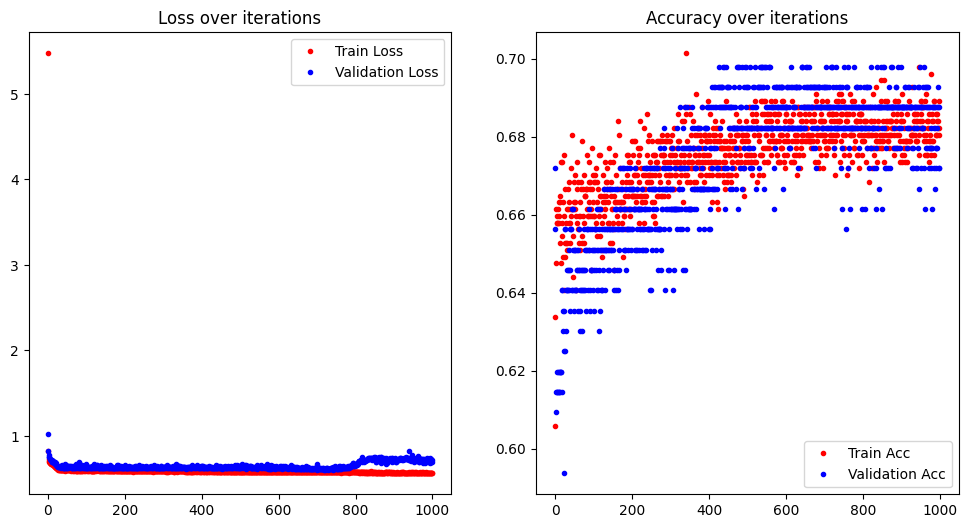

In [55]:
n = len(model_hist2.history["loss"])

fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(1, 2, 1)
ax.plot(range(n), (model_hist2.history["loss"]), 'r.', label="Train Loss")
ax.plot(range(n), (model_hist2.history["val_loss"]), 'b.', label="Validation Loss")
ax.legend()
ax.set_title('Loss over iterations')

ax = fig.add_subplot(1, 2, 2)
ax.plot(range(n), (model_hist2.history["accuracy"]), 'r.', label="Train Acc")
ax.plot(range(n), (model_hist2.history["val_accuracy"]), 'b.', label="Validation Acc")
ax.legend(loc='lower right')
ax.set_title('Accuracy over iterations')

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step  

accuracy is 0.6197916666666666
roc-auc is 0.5766662829515368


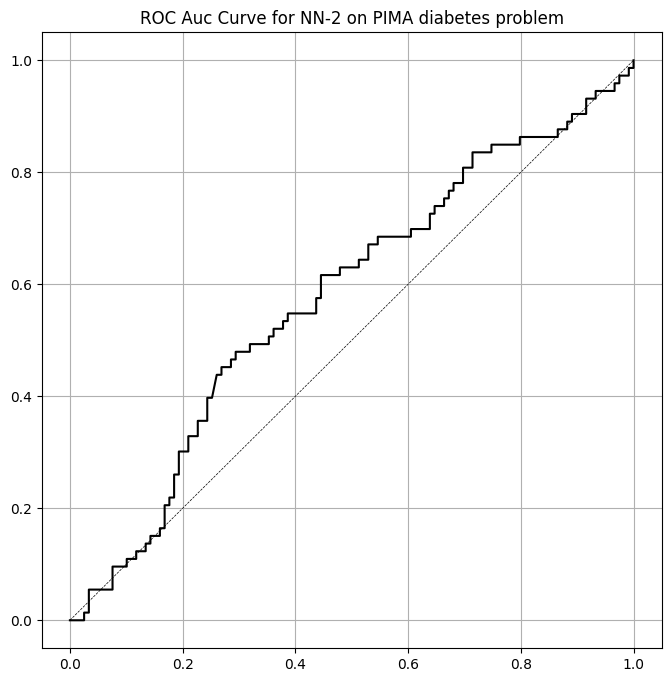

In [57]:
y_pred_prob_nn_2 = model2.predict(X_test_norm)
y_pred_class_nn_2 = (y_pred_prob_nn_2 > 0.5).astype(int)
print('')
print(f"accuracy is {accuracy_score(y_test, y_pred_class_nn_2)}")
print(f"roc-auc is {roc_auc_score(y_test, y_pred_prob_nn_2)}")

plot_roc(y_test, y_pred_prob_nn_2, 'NN-2')